In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
print(os.getcwd())
print(os.listdir())

/Users/donaldmurataj/Documents/Development/Paidy/credit-risk-prediction/src/credit_risk_prediction
['.DS_Store', 'modeling.ipynb', '__init__.py', 'py.typed', 'data', 'analysis.ipynb']


In [3]:
# Load datasets and ignore "Unnamed: 0" column on read
full_df = pd.read_csv("data/cs-training.csv", usecols=lambda c: c != "Unnamed: 0")

# Define type groups
int_columns = [
    'SeriousDlqin2yrs', 'age', 'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents'
]

float_columns = ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'MonthlyIncome']

# Convert types
full_df[int_columns] = full_df[int_columns].astype('Int64')
full_df[float_columns] = full_df[float_columns].astype(float)
full_df.shape

(150000, 11)

In [4]:
full_df.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.0,150000.000000,150000.0,150000.0,150000.000000,1.202690e+05,150000.0,150000.0,150000.0,150000.0,146076.0
mean,0.06684,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.45276,0.265973,1.01824,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.0,0.000000,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.029867,41.0,0.0,0.175074,3.400000e+03,5.0,0.0,0.0,0.0,0.0
50%,0.0,0.154181,52.0,0.0,0.366508,5.400000e+03,8.0,0.0,1.0,0.0,0.0
75%,0.0,0.559046,63.0,0.0,0.868254,8.249000e+03,11.0,0.0,2.0,0.0,1.0
max,1.0,50708.000000,109.0,98.0,329664.000000,3.008750e+06,58.0,98.0,54.0,98.0,20.0


In [5]:
null_counts = full_df.isnull().sum()
print(null_counts)

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64


### Let's see if the null monthly incomes just represents $0 (unemployed people). It's probably not because 30% is way too many

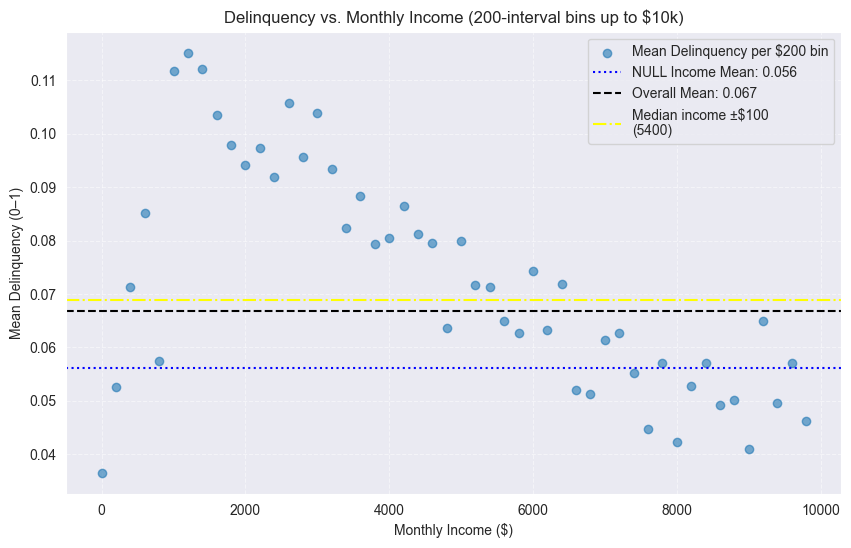

In [6]:
# Make safe copies
non_null_df = full_df[full_df['MonthlyIncome'].notnull()].copy()
null_df = full_df[full_df['MonthlyIncome'].isnull()].copy()

# Define fixed bins
bins = np.arange(0, 10100, 200)
labels = bins[:-1]  # label each bin by its lower bound

# Assign bins
non_null_df.loc[:, 'IncomeBin'] = pd.cut(
    non_null_df['MonthlyIncome'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Calculate mean delinquency per bin
bin_stats = (
    non_null_df.groupby('IncomeBin', observed=False)['SeriousDlqin2yrs']
    .mean()
    .reset_index()
    .rename(columns={'SeriousDlqin2yrs': 'MeanDelinquency'})
)

# Convert IncomeBin labels to numeric
bin_stats['IncomeBin'] = bin_stats['IncomeBin'].astype(float)

# Line of best fit
x = bin_stats['IncomeBin']
y = bin_stats['MeanDelinquency']
coeffs = np.polyfit(x, y, 1)
fit_line = np.poly1d(coeffs)

# Calculate delinquency rates
null_delinquency = null_df['SeriousDlqin2yrs'].mean()
overall_mean = full_df['SeriousDlqin2yrs'].mean()

# Median income and ±200 range
median_income = non_null_df['MonthlyIncome'].median()
lower_bound, upper_bound = median_income - 100, median_income + 100
median_group = non_null_df[(non_null_df['MonthlyIncome'] >= lower_bound) & (non_null_df['MonthlyIncome'] <= upper_bound)]
median_group_delinquency = median_group['SeriousDlqin2yrs'].mean()

# Plot scatter + best fit line + reference lines
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.6, label='Mean Delinquency per $200 bin')
plt.axhline(y=null_delinquency, color='blue', linestyle=':',
            label=f'NULL Income Mean: {null_delinquency:.3f}')
plt.axhline(y=overall_mean, color='black', linestyle='--',
            label=f'Overall Mean: {overall_mean:.3f}')
plt.axhline(y=median_group_delinquency, color='yellow', linestyle='-.',
            label=f'Median income ±$100\n({median_income:.0f})')


plt.title('Delinquency vs. Monthly Income (200-interval bins up to $10k)')
plt.xlabel('Monthly Income ($)')
plt.ylabel('Mean Delinquency (0–1)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

### Let's do the same analysis for the missing NumberOfDependents

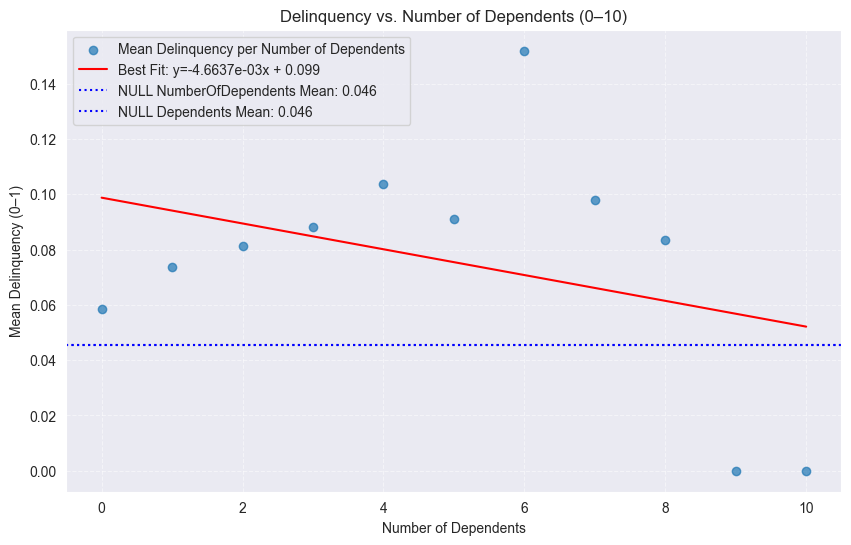

In [7]:
# --- Make safe copies ---
non_null_df = full_df[full_df['NumberOfDependents'].notnull()].copy()
null_df = full_df[full_df['NumberOfDependents'].isnull()].copy()

# --- Group by NumberOfDependents ---
dep_stats = (
    non_null_df.groupby('NumberOfDependents', observed=False)['SeriousDlqin2yrs']
    .mean()
    .reset_index()
    .rename(columns={'SeriousDlqin2yrs': 'MeanDelinquency'})
)

# Limit to 0–10 dependents for clarity
dep_stats = dep_stats[dep_stats['NumberOfDependents'] <= 10]

# --- Fit line of best fit ---
x = dep_stats['NumberOfDependents']
y = dep_stats['MeanDelinquency']
coeffs = np.polyfit(x, y, 1)
fit_line = np.poly1d(coeffs)

# --- Calculate reference delinquency rates ---
null_delinquency = null_df['SeriousDlqin2yrs'].mean() if not null_df.empty else np.nan
overall_mean = full_df['SeriousDlqin2yrs'].mean()

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.7, label='Mean Delinquency per Number of Dependents')
plt.plot(x, fit_line(x), color='red', label=f'Best Fit: y={coeffs[0]:.4e}x + {coeffs[1]:.3f}')
plt.axhline(y=null_delinquency, color='blue', linestyle=':',
            label=f'NULL NumberOfDependents Mean: {null_delinquency:.3f}')

if not np.isnan(null_delinquency):
    plt.axhline(y=null_delinquency, color='blue', linestyle=':',
                label=f'NULL Dependents Mean: {null_delinquency:.3f}')

plt.title('Delinquency vs. Number of Dependents (0–10)')
plt.xlabel('Number of Dependents')
plt.ylabel('Mean Delinquency (0–1)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

### Assume null dependants just means 0 (the average y-value is pretty close to that of 0 and it's also just 3000 data points, so it's not a big risk)

We can't do this for income though because that is 20% of our data as null and there's a bigger difference between the null mean and the 0 mean

In [8]:
full_df[['NumberOfDependents', 'SeriousDlqin2yrs']] = (
    full_df[['NumberOfDependents', 'SeriousDlqin2yrs']].fillna(0)
)
null_counts = full_df.isnull().sum()
print(null_counts)

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                          0
dtype: int64


### Let's Plot the distributions of each numeric column

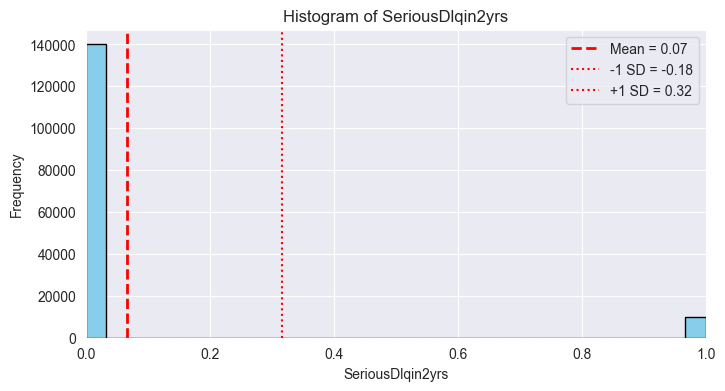

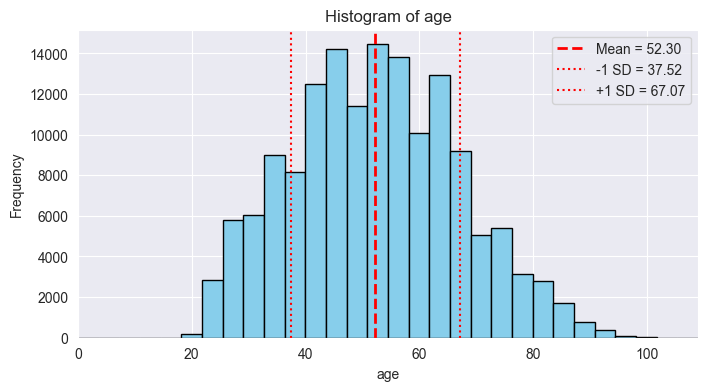

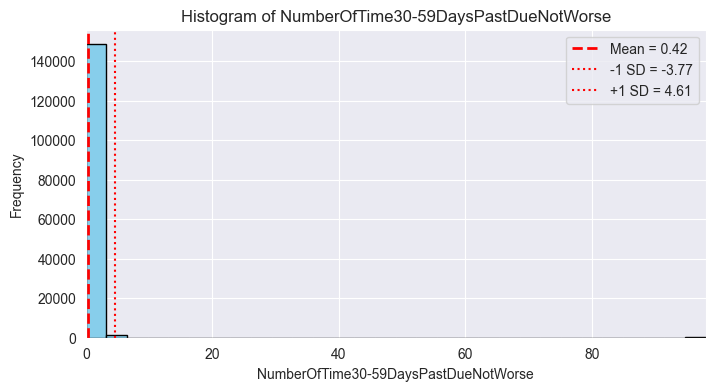

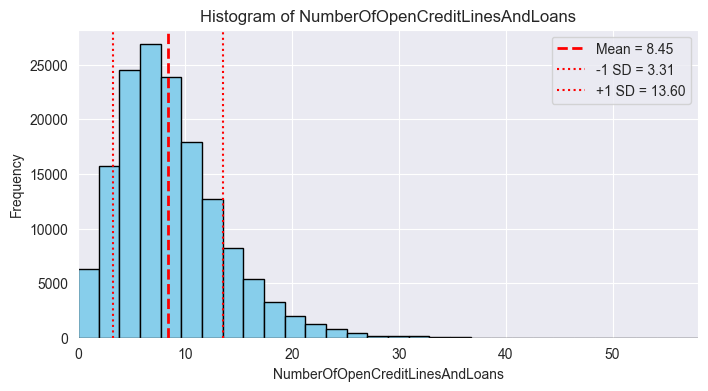

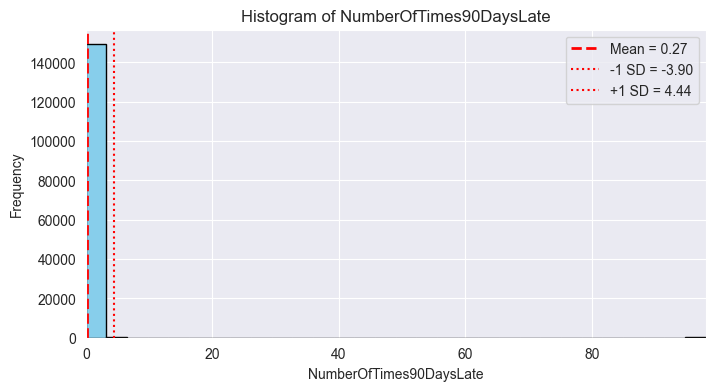

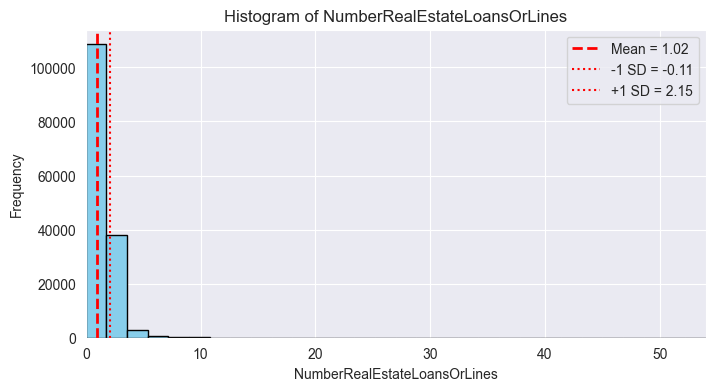

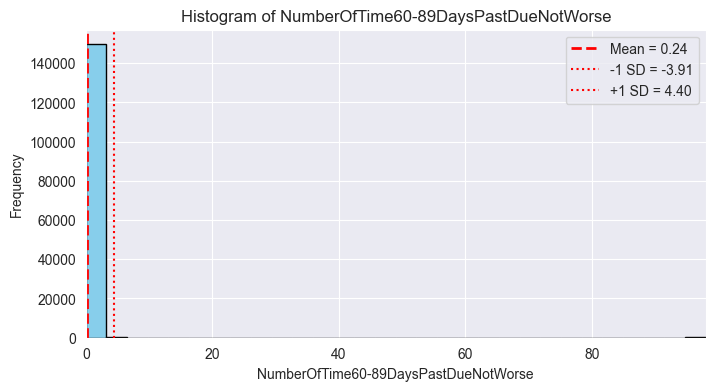

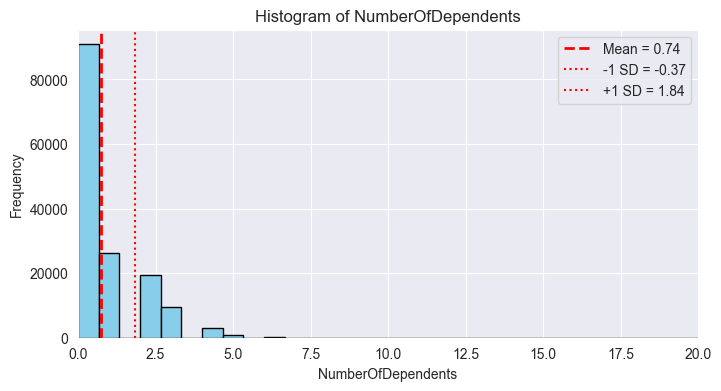

In [9]:
# Plot histograms for integer columns only
for col in int_columns:
    plt.figure(figsize=(8, 4))

    # Plot histogram
    full_df[col].hist(bins=30, color='skyblue', edgecolor='black')

    # Compute stats
    mean_val = full_df[col].mean()
    std_val = full_df[col].std()

    # Add vertical lines for mean and std dev
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_val:.2f}')
    plt.axvline(mean_val - std_val, color='red', linestyle=':', linewidth=1.5, label=f'-1 SD = {mean_val - std_val:.2f}')
    plt.axvline(mean_val + std_val, color='red', linestyle=':', linewidth=1.5, label=f'+1 SD = {mean_val + std_val:.2f}')

    # Set labels and title
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xlim(0, full_df[col].max())
    plt.legend()

    plt.show()

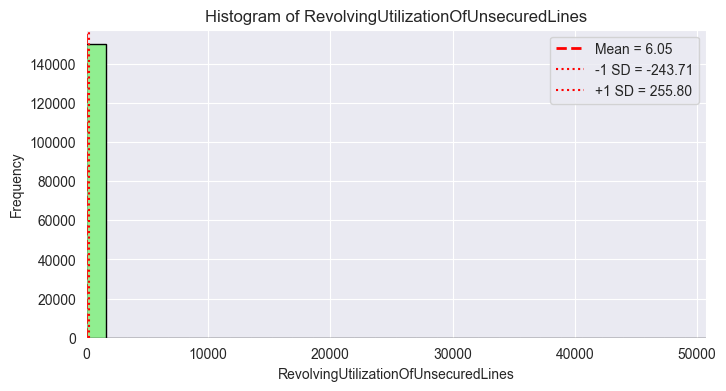

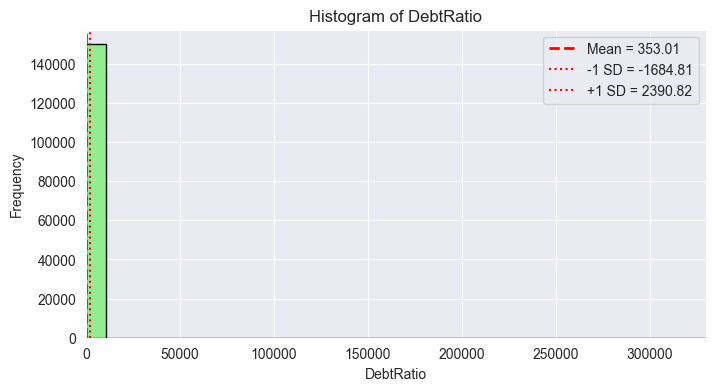

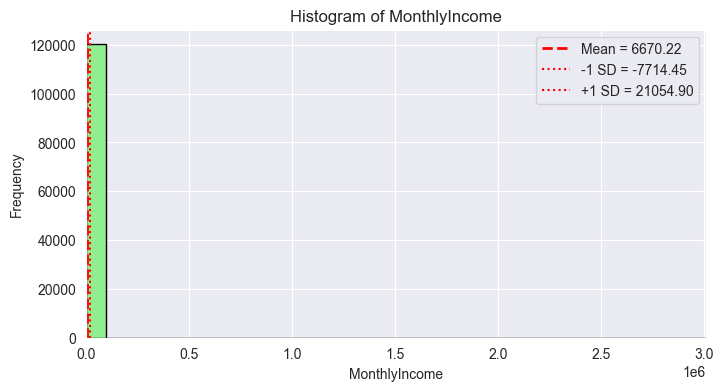

In [10]:
# Plot histograms for float columns
for col in float_columns:
    plt.figure(figsize=(8, 4))

    # Plot histogram
    full_df[col].hist(bins=30, color='lightgreen', edgecolor='black')

    # Compute stats
    mean_val = full_df[col].mean()
    std_val = full_df[col].std()

    # Add vertical lines for mean and std dev
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_val:.2f}')
    plt.axvline(mean_val - std_val, color='red', linestyle=':', linewidth=1.5, label=f'-1 SD = {mean_val - std_val:.2f}')
    plt.axvline(mean_val + std_val, color='red', linestyle=':', linewidth=1.5, label=f'+1 SD = {mean_val + std_val:.2f}')

    # Set labels and title
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xlim(0, full_df[col].max())
    plt.legend()

    plt.show()

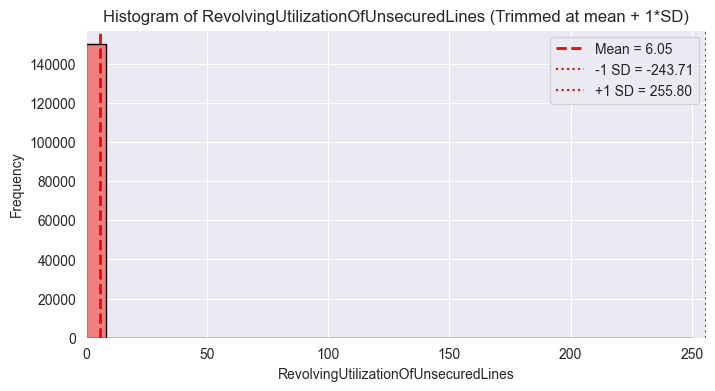

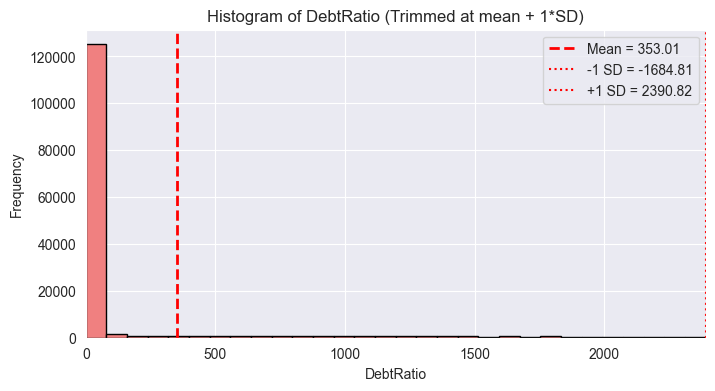

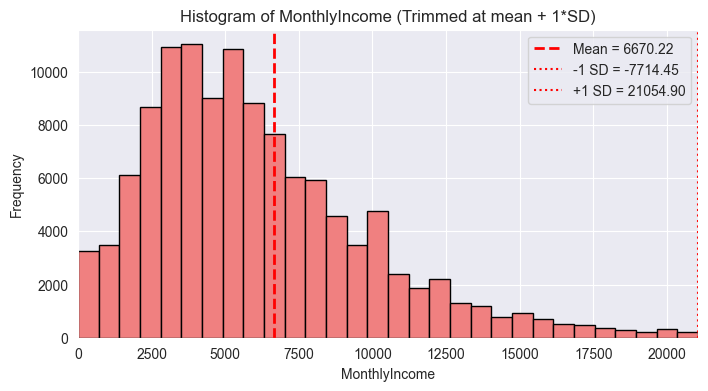

In [11]:
# Plot histograms for float columns, trimmed at mean + 2*std
for col in float_columns:
    plt.figure(figsize=(8, 4))

    # Compute stats
    mean_val = full_df[col].mean()
    std_val = full_df[col].std()
    upper_limit = mean_val + 1 * std_val

    # Filter data to be within 0 and mean + 2*std
    data_trimmed = full_df[col][(full_df[col] >= 0) & (full_df[col] <= upper_limit)]

    # Plot histogram
    data_trimmed.hist(bins=30, color='lightcoral', edgecolor='black')

    # Add vertical lines for mean and ±1 std (still inside the trimmed range)
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean_val:.2f}')
    plt.axvline(mean_val - std_val, color='red', linestyle=':', linewidth=1.5, label=f'-1 SD = {mean_val - std_val:.2f}')
    plt.axvline(mean_val + std_val, color='red', linestyle=':', linewidth=1.5, label=f'+1 SD = {mean_val + std_val:.2f}')

    # Set labels and title
    plt.title(f'Histogram of {col} (Trimmed at mean + 1*SD)')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xlim(0, upper_limit)
    plt.legend()

    plt.show()

### Summary

7% of users have had deliquency 90 days past or worse (out labeled data has imbalanced sets)

Population is quite old with population hovering between age 37 and 67

People have on average 8.5 credit lines open

Even though they are old, they usually have less than 1 dependant

average monthly income is about %6700

average debt ratio is over 300 (It's because of the extreme outliers)

In [12]:
percent_over_1 = (full_df['DebtRatio'] > 1).mean() * 100
median_debt_ratio = full_df['DebtRatio'].median()

print(f"{percent_over_1:.2f}% of people have a DebtRatio greater than 1.")
print(f"The median DebtRatio is {median_debt_ratio:.2f}.")


23.42% of people have a DebtRatio greater than 1.
The median DebtRatio is 0.37.


#### Now to check how maxxed out people's credit limits are

In [13]:
percent_over_1 = (full_df['RevolvingUtilizationOfUnsecuredLines'] > 1).mean() * 100
median_utilization = full_df['RevolvingUtilizationOfUnsecuredLines'].median()

print(f"{percent_over_1:.2f}% of people have a RevolvingUtilizationOfUnsecuredLines greater than 1.")
print(f"The median RevolvingUtilizationOfUnsecuredLines is {median_utilization:.2f}.")


2.21% of people have a RevolvingUtilizationOfUnsecuredLines greater than 1.
The median RevolvingUtilizationOfUnsecuredLines is 0.15.


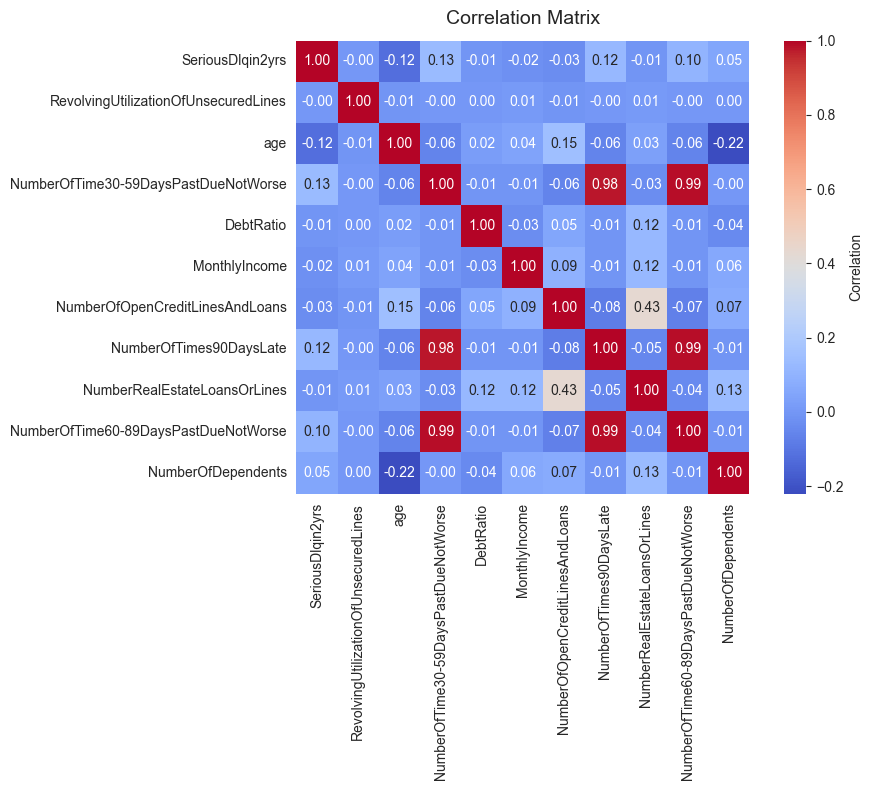

In [14]:
# Compute correlation matrix
corr_matrix = full_df.corr(numeric_only=True).round(2)

# Set up the plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,        # show the numbers
    fmt=".2f",         # format to 2 decimal places
    cmap="coolwarm",   # color map
    square=True,       # make cells square
    cbar_kws={'label': 'Correlation'}
)

plt.title("Correlation Matrix", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

### Insights from correlation
Age and dependents being negatively correlated makes sense because as you get older, your kids grow up and are no longer dependent

Older people are more likely to have loans as it's usually common to buy a house when you get older, that's why the positive correlation

number of loans and debt ratio being positively correlated makes sense because with more loans, you have more debt

dependents and real estate loans being positively correlated is interesting, I would love to investigate

Check if real estate loans is a subset of credit loans
Check if past due not worse is a subset of late

In [15]:
# Boolean masks
credit_positive = full_df['NumberOfOpenCreditLinesAndLoans'] > 0
real_estate_positive = full_df['NumberRealEstateLoansOrLines'] > 0

# --- Table 1: Focus on Credit Loans ---
credit_summary = pd.DataFrame({
    'Category': [
        'Credit = 0',
        'Credit > 0',
        'Credit > 0 & Real Estate = 0',
        'Credit > 0 & Real Estate > 0'
    ],
    'Count': [
        (~credit_positive).sum(),
        (credit_positive).sum(),
        (credit_positive & ~real_estate_positive).sum(),
        (credit_positive & real_estate_positive).sum()
    ]
})

credit_summary['Percentage'] = (credit_summary['Count'] / len(full_df) * 100).round(2)


# --- Table 2: Focus on Real Estate Loans ---
real_estate_summary = pd.DataFrame({
    'Category': [
        'Real Estate = 0',
        'Real Estate > 0',
        'Real Estate > 0 & Credit = 0',
        'Real Estate > 0 & Credit > 0'
    ],
    'Count': [
        (~real_estate_positive).sum(),
        (real_estate_positive).sum(),
        (real_estate_positive & ~credit_positive).sum(),
        (real_estate_positive & credit_positive).sum()
    ]
})

real_estate_summary['Percentage'] = (real_estate_summary['Count'] / len(full_df) * 100).round(2)

# Print both tables
print("---- Credit Loans Summary ----")
print(credit_summary.to_string(index=False))
print("\n---- Real Estate Loans Summary ----")
print(real_estate_summary.to_string(index=False))


---- Credit Loans Summary ----
                    Category  Count  Percentage
                  Credit = 0   1888        1.26
                  Credit > 0 148112       98.74
Credit > 0 & Real Estate = 0  54300       36.20
Credit > 0 & Real Estate > 0  93812       62.54

---- Real Estate Loans Summary ----
                    Category  Count  Percentage
             Real Estate = 0  56188       37.46
             Real Estate > 0  93812       62.54
Real Estate > 0 & Credit = 0      0        0.00
Real Estate > 0 & Credit > 0  93812       62.54


### As expected a real estate loan is a subset of a credit loan

In [16]:
# Boolean masks
late_60_89 = full_df['NumberOfTime60-89DaysPastDueNotWorse'] > 0
late_90_plus = full_df['NumberOfTimes90DaysLate'] > 0

# --- Table 1: Focus on 60–89 Days Past Due ---
late_60_89_summary = pd.DataFrame({
    'Category': [
        '60–89 Days Late = 0',
        '60–89 Days Late > 0',
        '60–89 Days Late > 0 & 90+ Days Late = 0',
        '60–89 Days Late > 0 & 90+ Days Late > 0'
    ],
    'Count': [
        (~late_60_89).sum(),
        (late_60_89).sum(),
        (late_60_89 & ~late_90_plus).sum(),
        (late_60_89 & late_90_plus).sum()
    ]
})

late_60_89_summary['Percentage'] = (late_60_89_summary['Count'] / len(full_df) * 100).round(2)


# --- Table 2: Focus on 90+ Days Late ---
late_90_plus_summary = pd.DataFrame({
    'Category': [
        '90+ Days Late = 0',
        '90+ Days Late > 0',
        '90+ Days Late > 0 & 60–89 Days Late = 0',
        '90+ Days Late > 0 & 60–89 Days Late > 0'
    ],
    'Count': [
        (~late_90_plus).sum(),
        (late_90_plus).sum(),
        (late_90_plus & ~late_60_89).sum(),
        (late_90_plus & late_60_89).sum()
    ]
})

late_90_plus_summary['Percentage'] = (late_90_plus_summary['Count'] / len(full_df) * 100).round(2)

# Print both tables
print("---- 60–89 Days Past Due Summary ----")
print(late_60_89_summary.to_string(index=False))
print("\n---- 90+ Days Late Summary ----")
print(late_90_plus_summary.to_string(index=False))

---- 60–89 Days Past Due Summary ----
                               Category  Count  Percentage
                    60–89 Days Late = 0 142396       94.93
                    60–89 Days Late > 0   7604        5.07
60–89 Days Late > 0 & 90+ Days Late = 0   4811        3.21
60–89 Days Late > 0 & 90+ Days Late > 0   2793        1.86

---- 90+ Days Late Summary ----
                               Category  Count  Percentage
                      90+ Days Late = 0 141662       94.44
                      90+ Days Late > 0   8338        5.56
90+ Days Late > 0 & 60–89 Days Late = 0   5545        3.70
90+ Days Late > 0 & 60–89 Days Late > 0   2793        1.86


### These are not subsets, but I understand the correlation because so many regular people (over 90%) will have never had either late payment and the few that did probably have been late many times

### Let's analyze the distributions of columns after removing outliers and log transforming

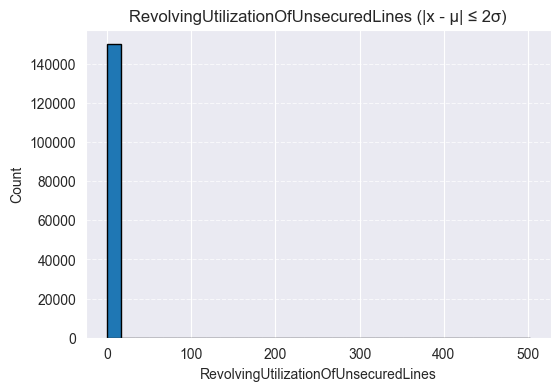

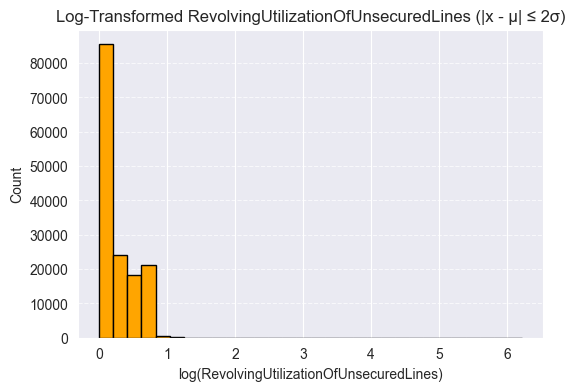

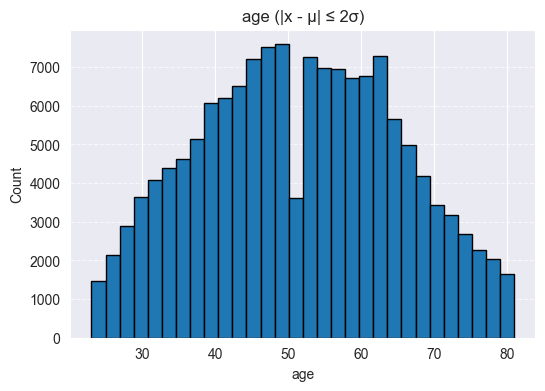

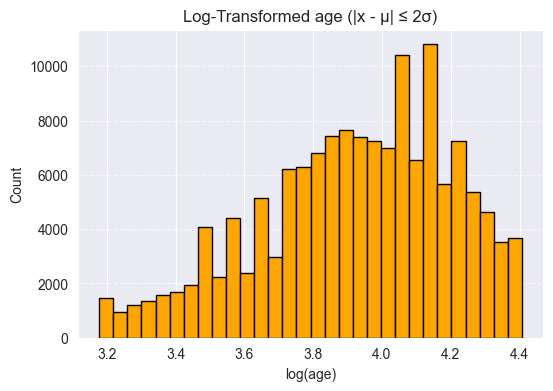

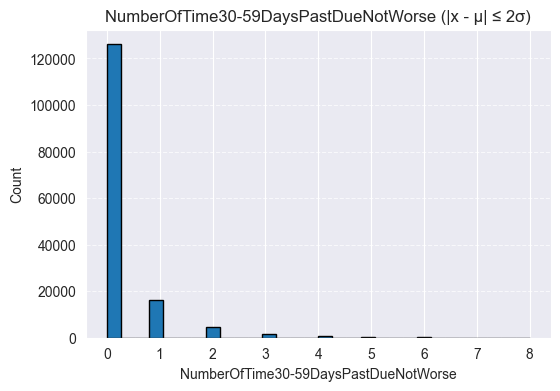

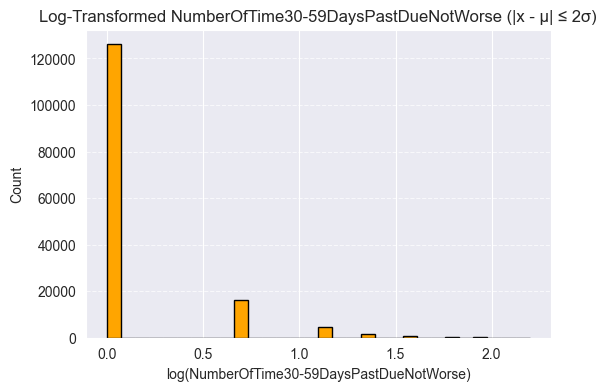

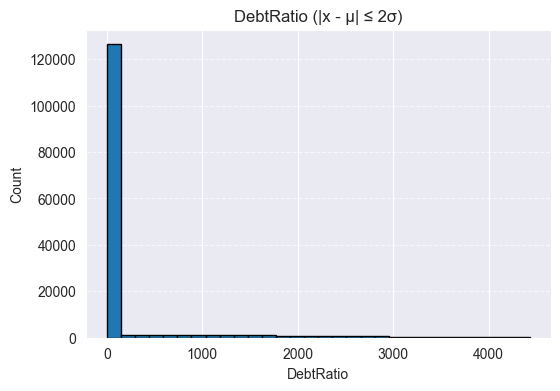

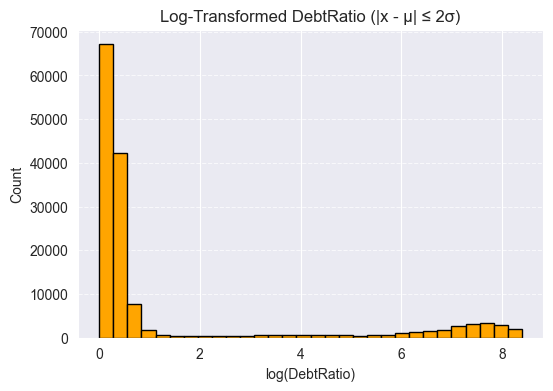

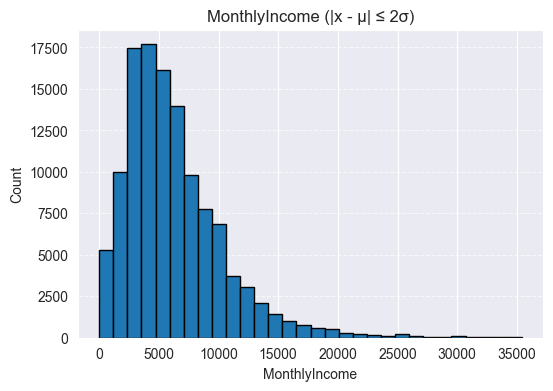

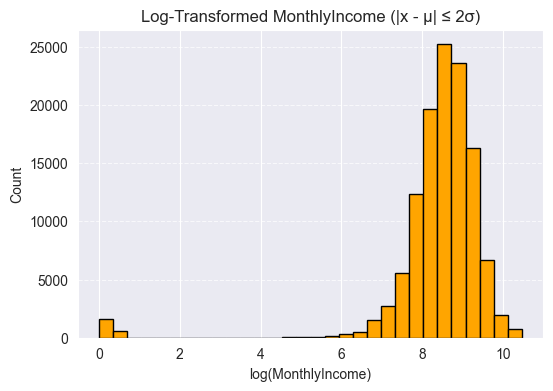

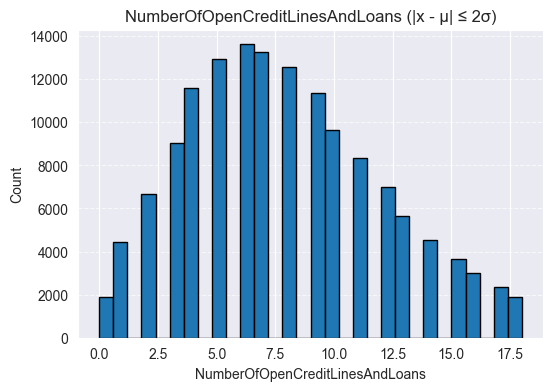

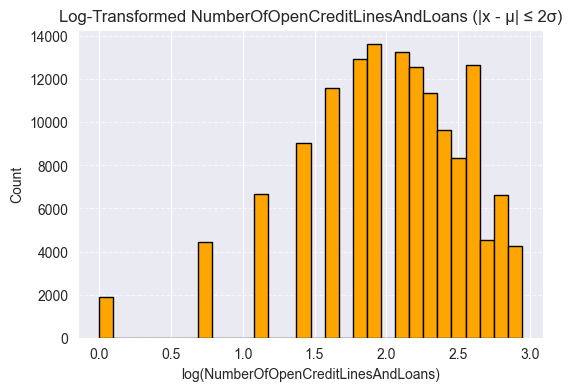

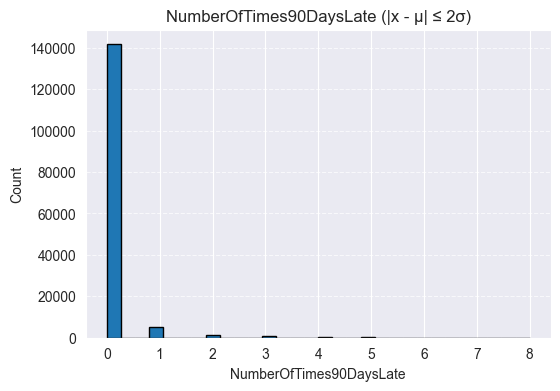

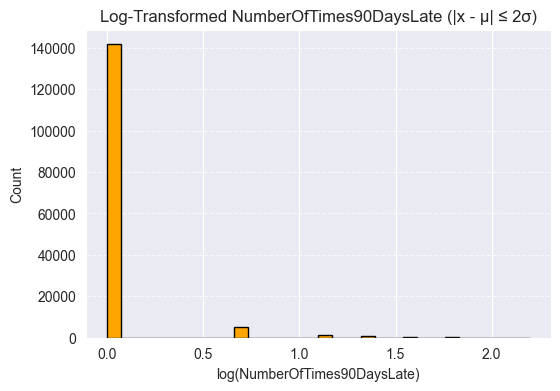

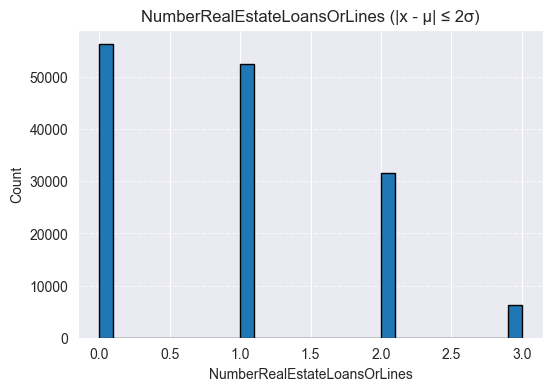

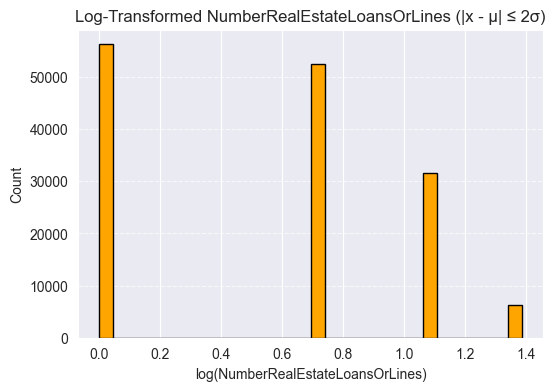

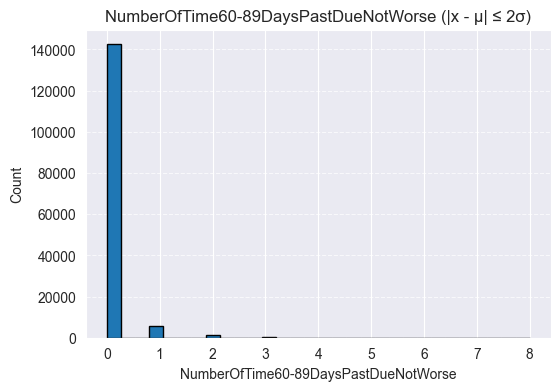

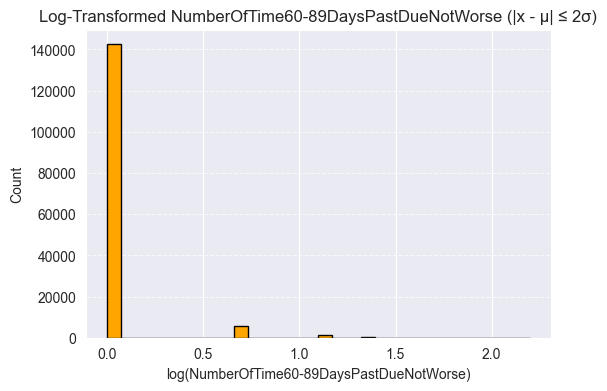

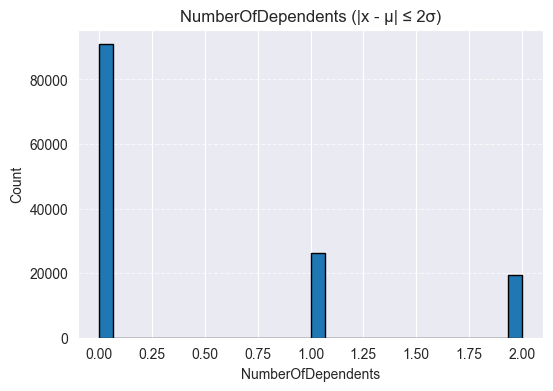

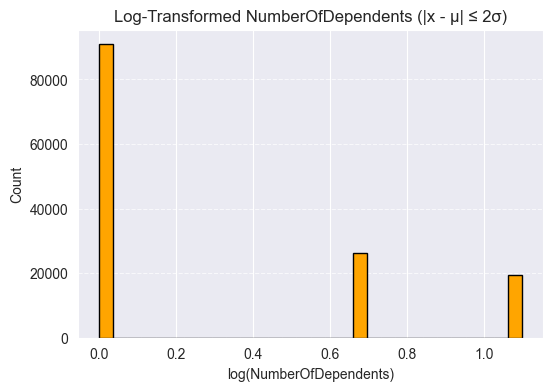

In [17]:
model_features = [
    'RevolvingUtilizationOfUnsecuredLines',
    'age',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents'
]

# --- Initialize empty placeholders for clarity ---
RevolvingUtilizationOfUnsecuredLines_no_outliers = None
RevolvingUtilizationOfUnsecuredLines_log = None
age_no_outliers = None
age_log = None
NumberOfTime30_59DaysPastDueNotWorse_no_outliers = None
NumberOfTime30_59DaysPastDueNotWorse_log = None
DebtRatio_no_outliers = None
DebtRatio_log = None
MonthlyIncome_no_outliers = None
MonthlyIncome_log = None
NumberOfOpenCreditLinesAndLoans_no_outliers = None
NumberOfOpenCreditLinesAndLoans_log = None
NumberOfTimes90DaysLate_no_outliers = None
NumberOfTimes90DaysLate_log = None
NumberRealEstateLoansOrLines_no_outliers = None
NumberRealEstateLoansOrLines_log = None
NumberOfTime60_89DaysPastDueNotWorse_no_outliers = None
NumberOfTime60_89DaysPastDueNotWorse_log = None
NumberOfDependents_no_outliers = None
NumberOfDependents_log = None

# --- Compute filtered and log-transformed versions ---
for col in model_features:
    # Remove NaN values
    data = full_df[col].dropna()

    # Calculate mean and std
    mean = data.mean()
    std = data.std()

    # Filter out values beyond 2 standard deviations
    filtered_data = data[(data >= mean - 2 * std) & (data <= mean + 2 * std)]

    # Create no_outliers and log versions
    globals()[f'{col}_no_outliers'] = filtered_data
    globals()[f'{col}_log'] = np.log1p(filtered_data)

    # Plot filtered distribution
    plt.figure(figsize=(6, 4))
    plt.hist(filtered_data, bins=30, edgecolor='black')
    plt.title(f'{col} (|x - μ| ≤ 2σ)')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Plot log-transformed distribution
    plt.figure(figsize=(6, 4))
    plt.hist(np.log1p(filtered_data), bins=30, edgecolor='black', color='orange')
    plt.title(f'Log-Transformed {col} (|x - μ| ≤ 2σ)')
    plt.xlabel(f'log({col})')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

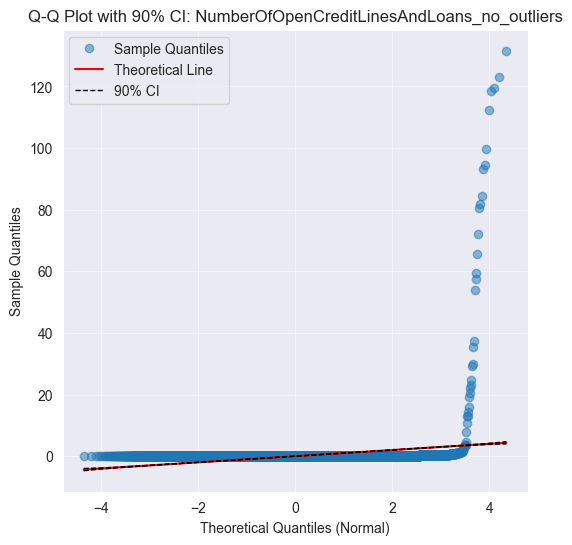

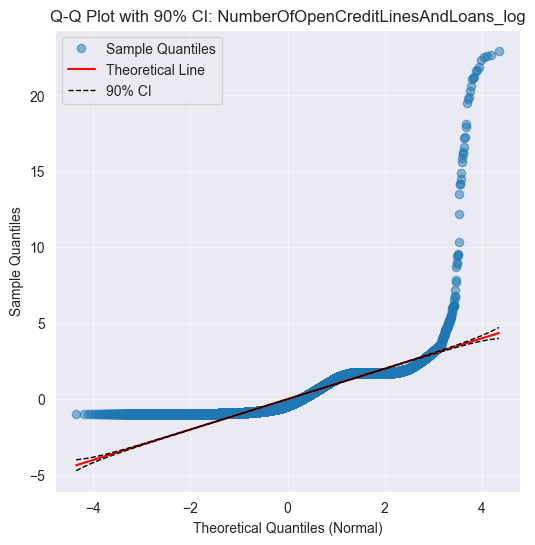

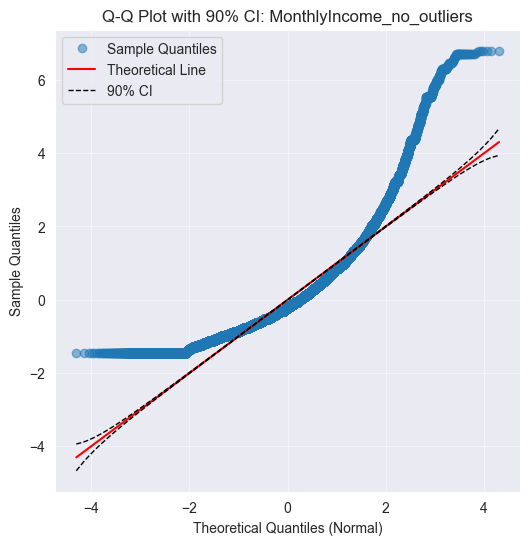

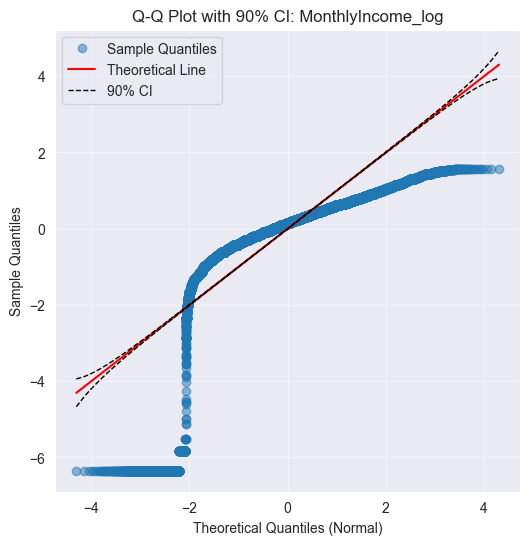

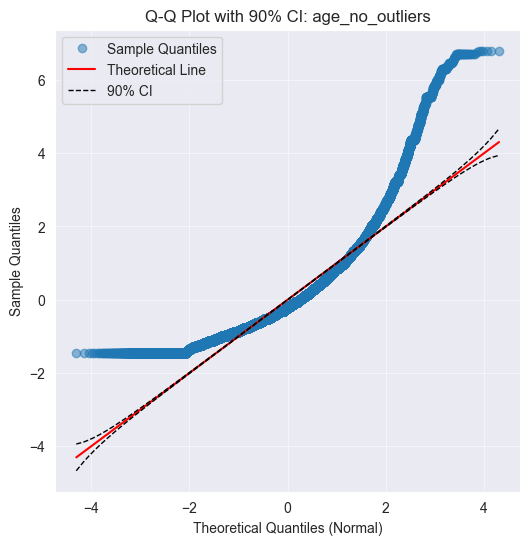

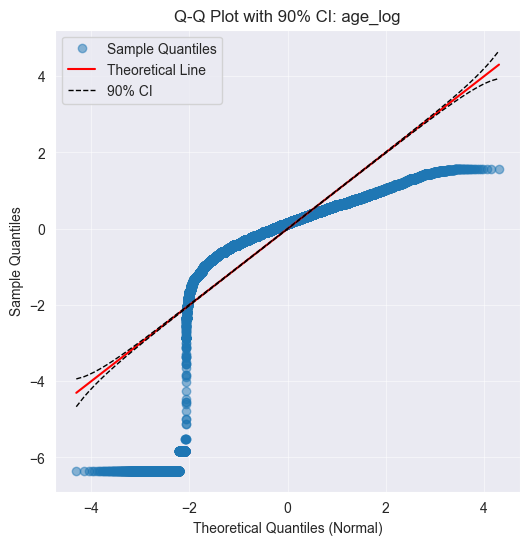

In [18]:
def qqplot_with_confidence(series, title, confidence=0.90):
    data = series.dropna().sort_values()
    n = len(data)

    # Theoretical quantiles from normal distribution
    quantiles = np.arange(1, n + 1) / (n + 1)
    theoretical_q = stats.norm.ppf(quantiles)

    # Sample quantiles (standardized)
    sample_q = np.sort(stats.zscore(data))

    # Z-value for confidence interval (90% = 1.645)
    z_val = stats.norm.ppf((1 + confidence) / 2)

    # Standard error and confidence bands
    se = (1.0 / stats.norm.pdf(theoretical_q)) * np.sqrt(quantiles * (1 - quantiles) / n)
    ci_upper = theoretical_q + z_val * se
    ci_lower = theoretical_q - z_val * se

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(theoretical_q, sample_q, 'o', label='Sample Quantiles', alpha=0.5)
    plt.plot(theoretical_q, theoretical_q, 'r-', label='Theoretical Line')
    plt.plot(theoretical_q, ci_upper, 'k--', linewidth=1, label=f'{int(confidence*100)}% CI')
    plt.plot(theoretical_q, ci_lower, 'k--', linewidth=1)

    plt.title(f'Q-Q Plot with {int(confidence*100)}% CI: {title}')
    plt.xlabel('Theoretical Quantiles (Normal)')
    plt.ylabel('Sample Quantiles')
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()


# Run for all 4 variables
qqplot_with_confidence(RevolvingUtilizationOfUnsecuredLines_no_outliers,
                       'NumberOfOpenCreditLinesAndLoans_no_outliers', confidence=0.90)

qqplot_with_confidence(RevolvingUtilizationOfUnsecuredLines_log,
                       'NumberOfOpenCreditLinesAndLoans_log', confidence=0.90)

qqplot_with_confidence(MonthlyIncome_no_outliers,
                       'MonthlyIncome_no_outliers', confidence=0.90)

qqplot_with_confidence(MonthlyIncome_log,
                       'MonthlyIncome_log', confidence=0.90)

qqplot_with_confidence(MonthlyIncome_no_outliers,
                       'age_no_outliers', confidence=0.90)

qqplot_with_confidence(MonthlyIncome_log,
                       'age_log', confidence=0.90)

#### I want to see what age buckets make sense to use in grouping for median income to replace the null values

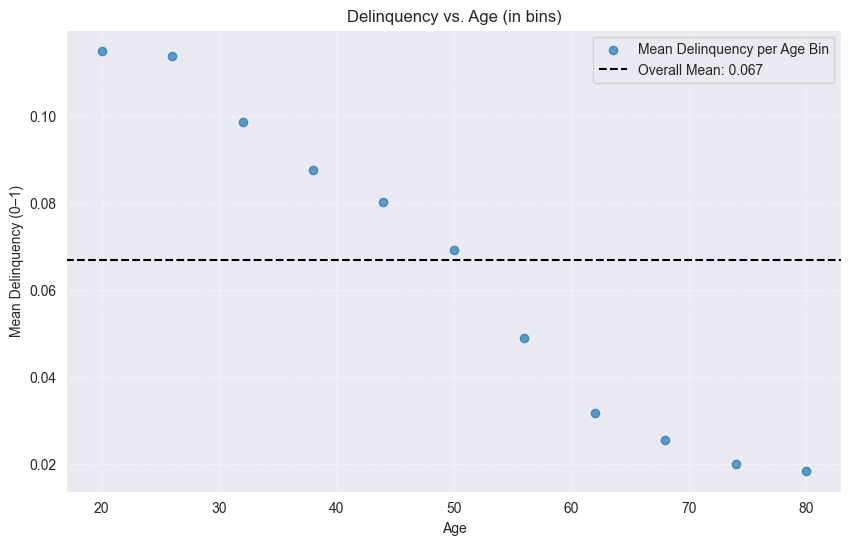

In [34]:
# --- Define bins for age (trial and error) ---
bins = np.arange(20, 90, 6)
labels = bins[:-1]  # label each bin by its lower bound

# Assign bins
if 'AgeBin' in full_df.columns:
    full_df = full_df.drop(columns='AgeBin')

full_df.loc[:, 'AgeBin'] = pd.cut(
    full_df['age'],
    bins=bins,
    labels=labels.astype(float),  # make sure labels are float for compatibility
    include_lowest=True
)

# --- Calculate mean delinquency per bin ---
bin_stats = (
    full_df.groupby('AgeBin', observed=False)['SeriousDlqin2yrs']
    .mean()
    .reset_index()
    .rename(columns={'SeriousDlqin2yrs': 'MeanDelinquency'})
)

# Convert AgeBin labels to numeric
bin_stats['AgeBin'] = bin_stats['AgeBin'].astype(float)

# --- Fit line of best fit ---
x = bin_stats['AgeBin']
y = bin_stats['MeanDelinquency']
coeffs = np.polyfit(x, y, 1)
fit_line = np.poly1d(coeffs)

# --- Calculate reference delinquency rates ---
null_delinquency = null_df['SeriousDlqin2yrs'].mean() if not null_df.empty else np.nan
overall_mean = full_df['SeriousDlqin2yrs'].mean()

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.7, label='Mean Delinquency per Age Bin')

plt.axhline(y=overall_mean, color='black', linestyle='--',
            label=f'Overall Mean: {overall_mean:.3f}')

plt.title('Delinquency vs. Age (in bins)')
plt.xlabel('Age')
plt.ylabel('Mean Delinquency (0–1)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

print("The bin of 6 is the smallest number that is monotonically decreasing, so we can confidently choose this as our bin")

### Decisions I made for transforming variables
The non-log-transformed versions of MonthlyIncome, age and NumberOfOpenCreditLinesAndLoans actually map better to normal, so we won't log transform these 2 for our model. I will be standardizing them all

NumberOfTime30_59DaysPastDueNotWorse, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTimes90DaysLate are discrete and over 95% of the data maps to 0, so for simplicity and prevention of overfitting, I think it's best to map all of these to 0 (responsible debt holders) and >0 (debt holders who make mistakes) to say

Debt ratio and RevolvingUtilizationOfUnsecuredLines are continuous, but so many values (over 95%) are under 1, that I think it's best to make 2 classes <1 and >= 1 since <1 in a way represents responsible borrowers, >=1 represents the few high risk borrowers

NumberRealEstateLoansOrLines and NumberOfDependents have very evenly spread discrete groups, but because they are pretty even and ordinal, I don't think it's necessary to convert to discrete data because we would lose information on severity while not helping any of our variable assumptions

For null monthly incomes, I'll do something smarter like take the median given the grouping that person is in based on their other variables. The age grouping will be based on 6-year bins